# Modelo para classificar relevância dos artigos do DOU
## Seção 1

Dado um conjunto de artigos do DOU classificados pela equipe na escala de 1 a 5 em relevância, vamos criar um modelo de machine learning para dar notas a novos artigos.

In [1]:
import pandas as pd
import utils as xu
import datetime as dt
import re
import numpy as np
import matplotlib.pyplot as pl
import mltools as ml
from importlib import reload

## Carrega os dados

Os dados são classificados diariamente pela equipe, e vai parar numa tabela do BigQuery. 
Nós podemos pegar, a cada dia, um número maior de artigos classificados.

### Cortes nos dados

Ao longo do processo de classificação manual, os critérios para seleção inicial dos artigos foram mudando. Aqui nós aplicamos os critétios mais atualizados para homogeneizar os dados selecionados.

In [2]:
query_1_cuts = """
secao = 1
AND (
     LOWER(identifica) LIKE '%decreto%' 
  OR LOWER(identifica) LIKE '%portaria%' 
  OR LOWER(identifica) LIKE '%resolu%'
  OR LOWER(identifica) LIKE '%medida provisória%'
  OR LOWER(identifica) LIKE '%lei %'
)
AND NOT REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND (orgao NOT LIKE '%Coordenação de Processos Migratórios%')
AND (orgao NOT LIKE '%Secretaria de Fomento e Incentivo à Cultura%')
AND (orgao NOT LIKE '%Departamento de Radiodifusão Comercial%')
"""

In [3]:
query_2_cuts = """
secao = 2
AND NOT REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário', 'Poder Legislativo')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário', 'Poder Legislativo')
AND (LOWER(orgao) NOT LIKE '%comando militar%')
AND (LOWER(orgao) NOT LIKE '%hospital%')
AND LOWER(fulltext) NOT LIKE '%conceder aposentadoria%' AND LOWER(fulltext) NOT LIKE '%aposentar%'
AND LOWER(fulltext) NOT LIKE '%conceder pensão%' 
AND LOWER(fulltext) NOT LIKE '%afastamento do país%'
"""

In [4]:
query_3_cuts = """
secao = 3
AND NOT REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
"""

In [5]:
query_e_cuts = """
REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
"""

In [6]:
base_query = "SELECT * FROM `gabinete-compartilhado.executivo_federal_dou.artigos_classificados`"
query_cuts = '('+ ') OR ('.join([query_1_cuts, query_2_cuts, query_3_cuts, query_e_cuts]) + ')'

get_classified_query = base_query + ' WHERE ' + query_cuts

### Carregando nossa classificação

Esta é a classificação de relevância das matérias do DOU, feitas pela equipe. A célula descomentada atualiza os dados com as novas classificações feitas e guardadas no nosso banco de dados. Para acessar dados antigos e já baixados, utilize a célula comentada que aparece logo em seguida.

In [7]:
today    = dt.datetime.now().strftime('%Y-%m-%d')
filename = '../dados/artigos_classificados_ate_' + today + '.csv'
print(xu.Bold('Arquivo com dados de hoje:'), filename)

Arquivo com dados de hoje: ../dados/artigos_classificados_ate_2021-09-17.csv


In [9]:
classified_raw = xu.load_data_from_local_or_bigquery(get_classified_query, filename)

Loading data from local file...


In [7]:
# Para carregar classificações feitas até uma certa data:
#classified_raw = pd.read_csv('../dados/artigos_classificados_ate_2021-09-17.csv')

In [11]:
n_null_url    = len(classified_raw.loc[classified_raw.url.isnull()])
frac_null_url = n_null_url / len(classified_raw)
print('Found', n_null_url, 'missing URLs in data ({:.1f}%)'.format(frac_null_url * 100))
print(xu.Bold('These will be removed!'))

Found 0 missing URLs in data (0.0%)
These will be removed!


In [12]:
def clean_versao_certificada(df):
    new = df.copy()
    new['fulltext'] = new['fulltext'].str.replace('^\s*?Versão certificada.*?Página: \d{1,3} Órgão: ', '')
    new['fulltext'] = new['fulltext'].str.replace('Este conteúdo não substitui o publicado na versão certificada.', '')
    return new

In [13]:
# We removed articles without urls because they shouldn't exist and we 
# will use urls as identifiers.
classified_w_url = clean_versao_certificada(classified_raw.loc[~classified_raw.url.isnull()])
print('Dados disponíveis:', len(classified_w_url))

Dados disponíveis: 14442


In [14]:
# Frequência de cada relevância na amostra classificada pela equipe:
dou_class_freq = classified_w_url.relevancia.value_counts(normalize=True)
dou_class_freq

1    0.520219
2    0.250519
3    0.097355
4    0.080114
5    0.051793
Name: relevancia, dtype: float64

### Brasil Real Oficial

As classificações de nível 5 são raras no DOU, e portanto a equipe classificar manualmente não é muito eficiente. Vamos usar os artigos citados no Brasil Real Oficial, desde o começo do ano de 2019, como exemplos de matérias de relevância 5 (máxima). 

In [26]:
base_bro_query = """
SELECT 

relevancia, identifica, secao, edicao, pagina, data_pub, orgao, ementa, resumo, fulltext, assina, 
cargo, url, url_certificado, data_registro 

FROM `gabinete-compartilhado.executivo_federal_dou.brasil_real_oficial_artigos_tab`
"""
bro_query = base_bro_query + ' WHERE identifica IS NOT NULL AND (' + query_cuts + ')'

In [31]:
bro_raw = xu.load_data_from_local_or_bigquery(bro_query, '../dados/test_bro_dou_cross_2.csv')
#bro_raw = xu.load_data_from_local_or_bigquery(bro_query, '../dados/bro_artigos_4null.csv')

Loading data from local file...


In [32]:
# Remove articles that are in our classification:
bro_no_repeat = clean_versao_certificada(bro_raw.loc[~bro_raw.url.isin(classified_w_url.url.values)])
print('Matérias distintas no BRO:', len(bro_no_repeat))

Matérias distintas no BRO: 396


In [33]:
# Classificação dada por nós para as matérias do BRO:
classified_w_url.loc[classified_w_url.url.isin(bro_raw.url)]['relevancia'].value_counts().sort_index(ascending=False)

5    29
4    14
3    18
2     6
1     6
Name: relevancia, dtype: int64

### Juntando Dados

Vamos criar uma base de dados com a junção da nossa classificação com a do BRO.

In [34]:
classified_n_bro = pd.concat([classified_w_url, bro_no_repeat], ignore_index=True, sort=False)
print('# Artigos:', len(classified_n_bro))
classified_n_bro = classified_n_bro.loc[~classified_n_bro.fulltext.isnull()]
print('# Artigos c/ texto:', len(classified_n_bro))

# Artigos: 14838
# Artigos c/ texto: 14821


## Selecionando seção e train validation test split

Precisamos fazer o split por data, para que o modelo seja treinado para prever o futuro.

In [35]:
# Select seção 1 and define a set splitting date:
secao = 1
min_test_date = '2020-07-30'

# Seleciona a seção:
classified_secao = classified_n_bro.loc[classified_n_bro.secao == secao]

# Split data into training, validation and test sets:
#train_raw, val_raw, test_raw = ml.train_val_test_split_by_date_n_string(classified_secao, 'data_pub', 
#                                                                        min_test_date, 
#                                                                        'url', 'http://www.in.gov.br/web/dou/-/')

# Randomly split dataset:
build_raw, test_raw = ml.train_test_split_by_string(classified_secao, 0.15, 'url', 'http://www.in.gov.br/web/dou/-/')
train_raw, val_raw  = ml.train_test_split_by_string(build_raw, 0.17, 'url', 'http://www.in.gov.br/')

In [36]:
# Check the amount of each class in each set:
n_ex_by_relevancia = pd.DataFrame()
n_ex_by_relevancia['train'] = train_raw.relevancia.value_counts()
n_ex_by_relevancia['val'] = val_raw.relevancia.value_counts()
n_ex_by_relevancia['test'] = test_raw.relevancia.value_counts()
assert n_ex_by_relevancia.isna().any().any() == False, 'Some set has missing classes'
n_ex_by_relevancia.sort_index()

,train,val,test
1,1760,375,389
2,831,153,169
3,516,96,102
4,426,82,79
5,463,88,102


## Testes de funções

Aqui podemos testar o desempenho das funções de pré-processamento.

In [37]:
# Test for extracting types of articles from the titles:
tryout = False
if tryout:
    for s in train_raw.identifica.values:
        print(s, ' >> ', do.get_article_type(s))

## Modelagem

Design do modelo

### Construção da pipeline

In [38]:
# Preprocessing:
import dou_sorter_common_functions as do
# Model evaluation:
import dou_model_eval as ev

In [39]:
import nltk
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import VotingRegressor

In [85]:
# Pré-processamento (s/ fit):
#text_cols = ['titulo', 'orgao', 'ementa', 'fulltext']
text_cols = ['tit_org_ementa_text']
colunas_relevantes = ['relevancia', 'tipo_edicao'] + text_cols

stopwords = nltk.corpus.stopwords.words('portuguese')

dou_extractor = do.PreprocessDOU(colunas_relevantes, 'xxnuloxx')

proc_text = do.PreProcessText(lowercase=False, remove_punctuation=True, keep_cash=True, stopwords=stopwords, 
                              stemmer=None, strip_accents=False, only_letters=False, cargo_tokens=True,
                              text_cols=text_cols)

preprocess = Pipeline([('dou', dou_extractor), ('pretext', proc_text)])

# Fit processing and model:
#vectorizer    = CountVectorizer(lowercase=False, binary=True, ngram_range=(1,2), max_df=1.0, min_df=1)
vectorizer    = TfidfVectorizer(lowercase=False, binary=True, ngram_range=(1,2), max_df=1.0, min_df=1, 
                                norm=None, use_idf=True)
#vectorizer    = ml.MultiColumnVectorizer(text_cols, [1,1,1,1], #[10,8,1.5,1], 
#                                         'max', 
#                                      lowercase=False, binary=True, ngram_range=(1,2), max_df=1.0, min_df=1)

encoder_extra = OneHotEncoder(drop='first')
processor     = ColumnTransformer([('vec',   vectorizer, text_cols[0]),
                                   ('extra', encoder_extra, ['tipo_edicao'])
                                  ])

#classifier  = ElasticNet(alpha=0.023, l1_ratio=0.4, selection='random', max_iter=5000)
classifier  = Ridge(10000)
#classifier  = LinearSVR(C=3e-3)
#classifier   = VotingRegressor([('ridge', Ridge(300)), ('svr', LinearSVR(C=3e-3))])
#classifier  = RandomForestRegressor()

#classifier  = Lasso(0.03, max_iter=4000, selection='random', tol=1e-4)
fit_pipe    = Pipeline([('proc', processor), ('fit', classifier)])
#fit_pipe    = Pipeline([('proc', vectorizer), ('fit', classifier)])

### Aplica pipeline ao dados

In [82]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import ParameterGrid

#### Busca nos hiperparâmetros

In [83]:
# Create a CV set and pre-process it:
train_val_concat = pd.concat([train_raw, val_raw], sort=False)
proc_train_val   = preprocess.transform(train_val_concat)

In [84]:
n_text_cols = 4
n_weight_sets = 20
max_weight = 9
weight_list = list(np.random.randint(1, max_weight + 1, n_text_cols * n_weight_sets).reshape((n_weight_sets, 
                                                                                         n_text_cols)))

In [86]:
param_grid = [{'fit__alpha': [300, 1000, 3000, 10000, 30000, 100000.0],
                #'fit__max_depth': [7,8,9,10,11,12],
                #'fit__n_estimators': [10, 20, 30],
                #'fit__C': [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2],
                #'fit__ridge__alpha': [300, 1000, 3000, 10000],
                #'fit__svr__C': [1e-3, 3e-3, 1e-2]
               #'proc__vec__text_weights': [[1,1,1,1]]
                #'fit__alpha': [1e-1, 1e-2]
               #'fit__alpha': [1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3],
               #'fit__l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01],
               #'proc__vec__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
               #'proc__vec__min_df': [1, 2, 4, 8, 16]
               #'proc__vec__max_df': [1.0],
               'proc__vec__binary': [True, False],
               'proc__vec__use_idf': [True, False],
               'proc__vec__norm': ['l2', 'l1', None],
               #'proc__vec__smooth_idf': [True, False],
               #'proc__vec__sublinear_tf':[True, False],
              #'proc__vec__min_df': [1, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9],
              #'proc__vec__ngram_range': [(1,1), (1,2)],
              #'proc__vec__ngram_range': [(1,1)],
              #'proc__extra': ['drop', encoder_extra],
              #'proc__extra': ['drop']
             }]

In [87]:
rank_scorer = make_scorer(ev.cum_recall_metric, greater_is_better=True)

# Do a Grid or Randomized search with fixed validation set:
test_fold = np.zeros(len(train_val_concat)).astype(int)
test_fold[:len(train_raw)] = -1
ps = PredefinedSplit(test_fold)
grid = GridSearchCV(fit_pipe, param_grid, cv=ps, scoring=rank_scorer, return_train_score=True, n_jobs=7)
#grid = RandomizedSearchCV(fit_pipe, param_grid, cv=ps, scoring=rank_scorer, return_train_score=True, n_jobs=7, n_iter=100)

In [88]:
# Run the hyper parameter search:
dump = grid.fit(proc_train_val, proc_train_val.relevancia.values)

print('Best score:', grid.best_score_)
print('Params:', grid.best_params_)

Best score: 0.848470588235294
Params: {'fit__alpha': 300, 'proc__vec__binary': True, 'proc__vec__norm': None, 'proc__vec__use_idf': False}


In [124]:
# Listagem dos melhores resultados:
grid_df = pd.DataFrame(grid.cv_results_)
target_cols = ['mean_test_score', 'mean_fit_time']
param_cols  = list(filter(lambda s: s.find('param_') != -1, grid_df.columns))
grid_df.sort_values(target_cols, ascending=[False, True])[target_cols + param_cols].head(10)

,mean_test_score,mean_fit_time,param_fit__alpha
1,0.803625,8.666782,300
0,0.795281,10.197287,100
2,0.787863,7.182891,1000
3,0.748273,7.015584,3000
4,0.690140,11.201975,10000


/home/skems/prog/my-python/mltools.py:1593: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


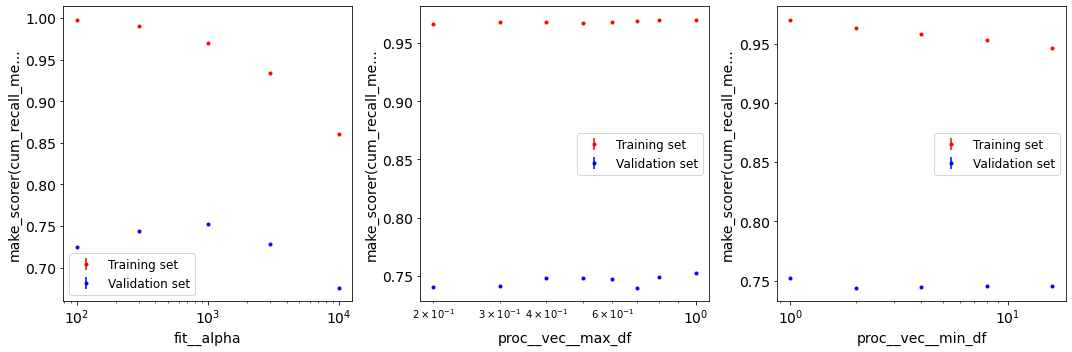

In [60]:
ml.plot_pars_scores(grid, logscale='force')

#### Avaliação do modelo

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
# Preprocess data:
proc_train = preprocess.transform(train_raw)
proc_val   = preprocess.transform(val_raw)

In [79]:
# Fit model:
fit_pipe.fit(proc_train, proc_train.relevancia.values)
# Predict:
pred_train = fit_pipe.predict(proc_train)
pred_val   = fit_pipe.predict(proc_val)

# Join validation true and predicted values:
y_pred_true_df = pd.DataFrame({'y_pred':pred_val, 'y_true': proc_val['relevancia'].values}, index=proc_val.index)

In [80]:
print('RMSE:       ', np.sqrt(mean_squared_error(proc_val.relevancia.values, pred_val)))
print('Cum. Recall:', ev.cum_recall_metric(proc_val.relevancia.values, pred_val))

RMSE:        0.871605099498527
Cum. Recall: 0.8261270588235297


In [85]:
# Cria pesos para amostragem balançeada:
n_val = len(proc_val)
n_balanced_sample = (dou_class_freq * n_val).round().astype(int) / y_pred_true_df['y_true'].value_counts()
n_balanced_sample = n_balanced_sample.rename('n_balanced')

# Junta pesos à base:
y_pred_true_to_sample = y_pred_true_df.join(n_balanced_sample, on='y_true', how='left')

# Mede performance em amostras bootstrap:
n_trials = 10
rmse_list      = []
cumrecall_list = []
for i in range(n_trials):
    balanced_sample = y_pred_true_to_sample.sample(n=n_val, replace=True, weights='n_balanced')
    rmse_list.append(np.sqrt(mean_squared_error(balanced_sample.y_true.values, balanced_sample.y_pred.values)))
    cumrecall_list.append(np.sqrt(ev.cum_recall_metric(balanced_sample.y_true.values, balanced_sample.y_pred.values)))

# Resultados:
print('RMSE:       ', ml.mean_dev_scores(rmse_list))
print('Cum. Recall:', ml.mean_dev_scores(cumrecall_list))

RMSE:        (1.0167495046589115, 0.04162173975080288)
Cum. Recall: (0.8880286179659423, 0.01924048746822173)


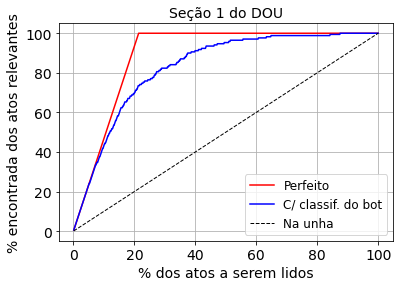

In [57]:
ev.plot_recall_curve(proc_val.relevancia.values, pred_val)

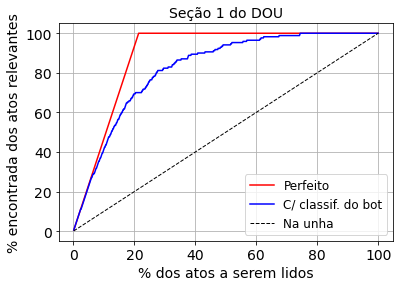

In [53]:
ev.plot_recall_curve(proc_val.relevancia.values, pred_val)

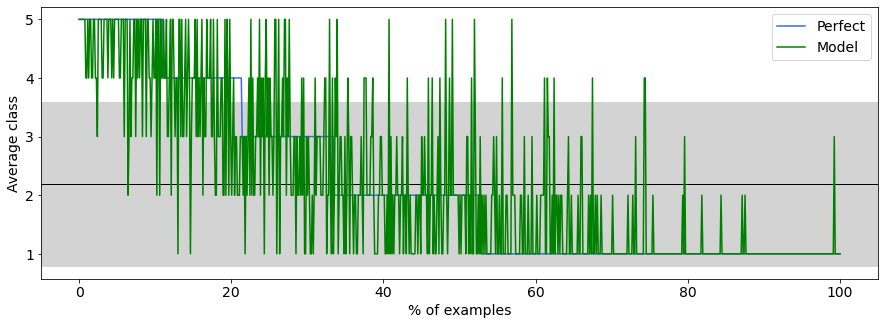

In [54]:
window = 1

pl.figure(figsize=(15,5))
ev.plot_average_rank(proc_val['relevancia'].values, proc_val['relevancia'].values, window, 
                  color='royalblue', label='Perfect')
ev.plot_average_rank(proc_val['relevancia'].values, pred_val, window, color='g', label='Model')
pl.legend(fontsize=14)
pl.show()

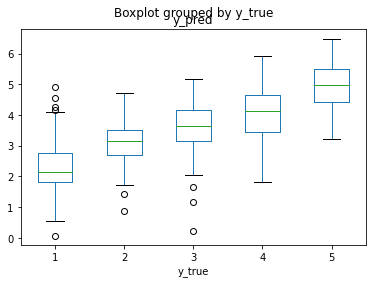

In [59]:
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
#pl.savefig('plots/box-plot_rank_by_true_label_' + dt.datetime.now().strftime('%Y-%m-%d') + '.png')
pl.show()

In [60]:
y_pred_true_df.loc[y_pred_true_df.y_true.isin([4,5])]['y_pred'].min()

1.8116477873002972

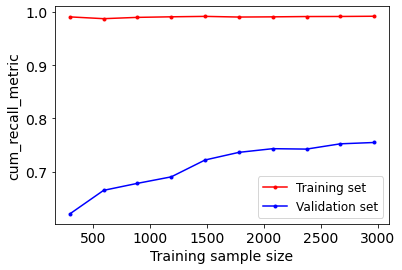

In [90]:
ml.plot_learning_curve_old(fit_pipe, ev.cum_recall_metric, proc_train, proc_train.relevancia.values,
                           proc_val, proc_val.relevancia.values, 10)

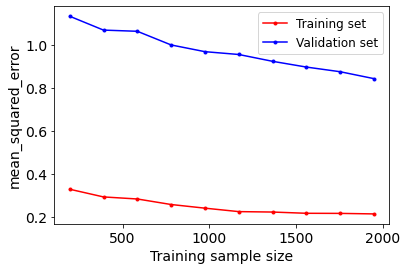

In [136]:
ml.plot_learning_curve_old(fit_pipe, mean_squared_error, proc_train, proc_train.relevancia.values,
                           proc_val, proc_val.relevancia.values, 10)

#### Peso das palavras

In [137]:
word_weight_df = pd.DataFrame()
word_weight_df['word']   = pd.Series(fit_pipe.named_steps['proc'].transformers_[0][1].get_feature_names())
word_weight_df['weight'] = pd.Series(fit_pipe.named_steps['fit'].coef_)

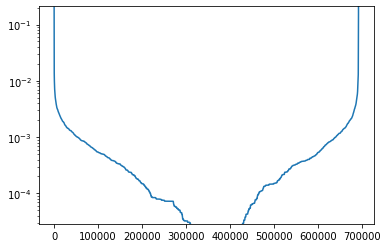

In [138]:
word_weights = word_weight_df['weight'].sort_values().values
pl.plot(np.abs(word_weights))
pl.yscale('log')
pl.ylim([20 / len(word_weights), np.max(np.abs(word_weights))])
pl.show()

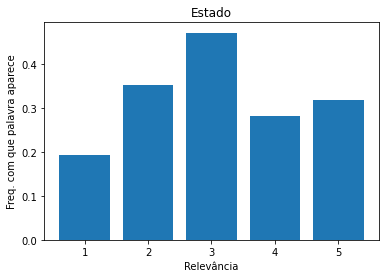

In [139]:
word_weight_pos = 14
word = word_weight_df.sort_values('weight').iloc[word_weight_pos]['word']
counts = proc_train.loc[proc_train[text_cols].agg(' '.join, axis=1).str.contains(word)]['relevancia'].value_counts()
total  = proc_train['relevancia'].value_counts()
freq   = counts / total
pl.bar(freq.index, freq.values)
pl.title(word)
pl.xlabel('Relevância')
pl.ylabel('Freq. com que palavra aparece')
pl.show()

### Identificando textos similares

Aqui nós podemos identificar os erros catastróficos do modelo e ver com quais dados do treino eles se parecem, para eventualmente detectar erros na base de dados.

#### Funções

In [140]:
from sklearn.base import clone

In [141]:
from sklearn.metrics.pairwise import euclidean_distances

def text_similarity_matrix(corpus, vectorizer, target_r2):
    output = {}
    
    # Transform corpus into a centred (zero mean for columns) 
    # matrix (rows are texts and columns are tokens):
    matrix = vectorizer.fit_transform(corpus).toarray()
    matrix_mean = matrix.mean(axis=0)
    matrix_centred = matrix - matrix_mean
    
    output['vocab'] = np.array(vectorizer.get_feature_names())
    output['mean_vector'] = matrix_mean
    output['term_matrix'] = matrix
    
    term_freq  = np.transpose(np.transpose(matrix) / np.sqrt(matrix.sum(axis=1)))
    binary_cov = term_freq.dot(term_freq.transpose())
    np.fill_diagonal(binary_cov, 0)
    output['similarity'] = binary_cov
    
    # SVD:
    #U, s, Vh  = np.linalg.svd(matrix_centred, full_matrices=False)

    #r2_by_component = np.cumsum(s**2) / np.sum(s**2)

    # Get text main features:
    #last_component = np.argmin(np.abs(r2_by_component - target_r2))
    #print('# components:', last_component)
    #text_features  = U[:, :last_component] * np.sqrt(len(matrix))
    #output['text_features'] = text_features
    
    # Compute the distance between texts:
    #output['text_distance'] = euclidean_distances(text_features)
    
    return output

In [142]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [143]:
def plot_word_vector(vocab, vector):
    """
    Plot a wordcloud for words in `vocab` with frequency given by `vector`.
    Positive frequencies are plot in blue, negative frequencias as plot in red.
    """
    
    assert np.shape(vocab) == np.shape(np.array(vector)), '`vocab` and `vector` must have the same shape.'
    assert type(vocab[0]) == str or type(vocab[0]) == np.str_, '`vocab` must be a array-like of strings.'
    
    from wordcloud import (WordCloud, get_single_color_func)
    wc = WordCloud(background_color='white', relative_scaling=0.8, include_numbers=True, width=800, height=400)

    abs_vector = np.abs(vector)
    # Set word sizes:
    word_frequencies = {word:weight for word, weight in zip(vocab, abs_vector)}
    # Define colors of words (negatives are red, positives are blue):
    plus_words  = [word for word, weight in zip(vocab, vector) if weight > 0]
    minus_words = [word for word, weight in zip(vocab, vector) if weight < 0]
    color_to_words =  {'blue': plus_words, 'red': minus_words}
    default_color  = 'grey'
    
    # Generate wordcloud:
    wc.generate_from_frequencies(word_frequencies)
    # Color words according to their signs:
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    wc.recolor(color_func=grouped_color_func)
    
    #pl.figure(figsize=(12,7))
    pl.imshow(wc, interpolation="bilinear")
    pl.axis("off")

In [144]:
def build_similarity_df(train, test, vectorizer):
    """
    Compute the similarity between texts stored in `train` and 
    `test` Pandas series. To vectorize the text, it uses 
    `vectorizer` (assumed with option binary=True). The similarity 
    is the number of common tokens normalized to the geometric mean
    of the number of tokens in each text.
    
    Output: A Pandas DataFrame where the rows are train texts and 
    the columns are test texts (the indices of rows and columns are 
    the text indices).
    """
    
    # Vectorize texts:
    vec = clone(vectorizer)
    train_matrix = vec.fit_transform(train)
    test_matrix  = vec.transform(test)

    # Create text similarity df:
    norm_train = np.diag(1 / np.sqrt(train_matrix.sum(axis=1).A1))
    norm_test  = np.diag(1 / np.sqrt(test_matrix.sum(axis=1).A1))
    common_word_counts = train_matrix.dot(test_matrix.transpose()).toarray()
    similarity_matrix  = norm_train.dot(common_word_counts).dot(norm_test)
    similarity_df = pd.DataFrame(similarity_matrix, index=train.index, columns=test.index)
    
    return similarity_df

In [145]:
def analise_similarity_with(test_idx, train_df, test_df, similarity_df, sim_thresh, max_matches,
                            class_col='relevancia', text_col='url'):
    """
    Print information about the best matching training texts to a given test text:
    - Class, similarity and text (or link);
    - Plot of the ordered similarities above `sim_thresh` threshold;
    - Histogram of the train text classes with similarities above `sim_thresh`.
    
    Input
    -----
    
    test_idx : Pandas DataFrame index
        The index of the test text stored in `test_df`.
        
    train_df : Pandas DataFrame
        The training dataset containing the texts tested for similarity with 
        the test text.
        
    test_df : Pandas DataFrame
        The test dataset containing the test text with index given by `test_idx`.
        
    similarity_df : Pandas DataFrame
        A matrix with similarities between test texts (columns) and train texts (rows).
        Computed by the `build_similarity_df` function.
        
    sim_thresh : float
        Minimum similarity used to select texts from `train_df`.
        
    max_matches : int
        Maximum number of train texts whose information is printed. 
    """
    # Print test text info:
    print(xu.Bold('Test text') + ' (class {:d})'.format(test_df.loc[test_idx, class_col]))
    print(test_df.loc[test_idx, text_col])

    # Find most similar texts in train sample:
    test_ex_similarity = similarity_df[test_idx]
    train_best_matches = test_ex_similarity.loc[test_ex_similarity > sim_thresh].sort_values(ascending=False)
    train_best_matches_top = train_best_matches.head(max_matches)
    best_matches_df = train_df.loc[train_best_matches_top.index]

    # Print info about train text:
    print(xu.Bold('Train texts'))
    for i in best_matches_df.index:
        print('(class {:d}  sim. {:.4f})  {:s}'.format(best_matches_df.loc[i, class_col], 
                                                       train_best_matches[i], 
                                                       best_matches_df.loc[i, text_col]))
    
    pl.figure(figsize=(10,4))
    # Plot similarities above threshold:
    pl.subplot(1,2,1)
    pl.plot(train_best_matches.sort_values(ascending=False).values)
    pl.xlabel('Posição do texto de treino')
    pl.ylabel('Similaridade com texto teste')
    # Plot histogram of classes of similar texts:
    pl.subplot(1,2,2)
    sim_train_class_counts = train_df.loc[train_best_matches.index, 'relevancia'].value_counts()
    pl.bar(sim_train_class_counts.index, sim_train_class_counts.values)
    pl.xlabel('Relevância do texto de treino')
    pl.ylabel('# textos de treino')

#### Aplicação

In [146]:
# Compute similarity between texts:
similarity_df = build_similarity_df(proc_train.tit_org_ementa_text, proc_val.tit_org_ementa_text, vectorizer)

In [147]:
# Get validation data true values and predictions:
test_df   = proc_val
test_pred = pred_val
y_pred_true_df = pd.DataFrame({'y_pred':test_pred, 'y_true': test_df['relevancia'].values}, index=test_df.index)

In [149]:
# Select kind of error to check:
y_pred_true_df.loc[(y_pred_true_df.y_true.isin([4,5])) & (y_pred_true_df.y_pred < 2.5)]

,y_pred,y_true
260,2.245951,4
1825,2.494436,5
5941,2.417610,4


In [151]:
# Select kind of error to check:
y_pred_true_df.loc[(y_pred_true_df.y_true.isin([1,2])) & (y_pred_true_df.y_pred > 3.5)]

,y_pred,y_true
240,4.095901,2
382,4.137840,2
823,3.693878,2
1519,3.931638,2
2053,3.581182,2
2336,3.647940,2
3994,4.187009,2
4012,3.848293,2
4855,3.583843,2


Test text (class 2)
http://www.in.gov.br/web/dou/-/decreto-n-10.399-de-16-de-junho-de-2020-261925290
Train texts
(class 5  sim. 0.7702)  http://www.in.gov.br/web/dou/-/decreto-n-10.186-de-20-de-dezembro-de-2019-234972154
(class 5  sim. 0.4317)  http://www.in.gov.br/web/dou/-/decreto-n-10.351-de-18-de-maio-de-2020-257394436
(class 3  sim. 0.3956)  http://www.in.gov.br/web/dou/-/decreto-n-10.391-de-5-de-junho-de-2020-260558270
(class 5  sim. 0.3826)  http://www.in.gov.br/web/dou/-/decreto-n-10.155-de-4-de-dezembro-de-2019-231561864
(class 5  sim. 0.3548)  http://www.in.gov.br/web/dou/-/decreto-n-10.123-de-21-de-novembro-de-2019-229122493
(class 2  sim. 0.3450)  http://www.in.gov.br/web/dou/-/decreto-n-10.371-de-22-de-maio-de-2020-258265713
(class 2  sim. 0.3276)  http://www.in.gov.br/web/dou/-/decreto-n-10.383-de-28-de-maio-de-2020-259144128
(class 5  sim. 0.3272)  http://www.in.gov.br/web/dou/-/decreto-n-10.113-de-12-de-novembro-de-2019-227655443
(class 5  sim. 0.3255)  http://www.in.go

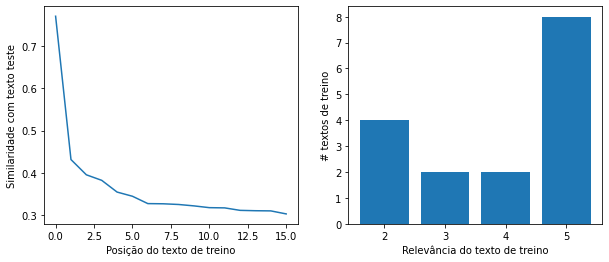

In [155]:
analise_similarity_with(3994, train_raw, val_raw, similarity_df, 0.30, 100)

## Colocando em produção

### Cria modelo de teste para registro

In [ ]:
# Fit to train and validation set; test on test set:
#final_test_pipeline = do.create_model()
#dump = final_test_pipeline.fit(train_val_concat, train_val_concat.relevancia.values)
# Predict:
#y_test_pred = final_test_pipeline.predict(test_raw)
# Evaluate:
#test_score  = ev.cum_recall_metric(test_raw.relevancia.values, y_test_pred)
#print('RMSE:       ', np.sqrt(mean_squared_error(test_raw.relevancia.values, y_test_pred)))
#print('Cum. Recall:', test_score)

In [93]:
reload(do)

<module 'dou_sorter_common_functions' from '/home/skems/gabinete/projetos/fiscalizacao/executivo/analises/dou_sorter_common_functions.py'>

In [94]:
# Create and fit model to train data:
final_test_pipeline = do.create_model_sec1()
dump = final_test_pipeline.fit(train_raw, train_raw.relevancia.values)
#dump = final_test_pipeline.fit(train_val_concat, train_val_concat.relevancia.values)

In [95]:
# Predict for the validation set:
y_train_pred = final_test_pipeline.predict(train_raw) 
y_val_pred   = final_test_pipeline.predict(val_raw)
# Evaluate:
train_score  = ev.cum_recall_metric(train_raw.relevancia.values, y_train_pred)
val_score    = ev.cum_recall_metric(val_raw.relevancia.values,  y_val_pred)
print('RMSE:       ', np.sqrt(mean_squared_error(val_raw.relevancia.values, y_val_pred)))
print('Cum. Recall:', val_score)

RMSE:        0.9853898980350612
Cum. Recall: 0.7546425977798528


In [96]:
# Predict for the test set:
y_train_pred = final_test_pipeline.predict(train_raw) 
y_test_pred  = final_test_pipeline.predict(test_raw)
# Evaluate:
train_score  = ev.cum_recall_metric(train_raw.relevancia.values, y_train_pred)
test_score   = ev.cum_recall_metric(test_raw.relevancia.values,  y_test_pred)
print('RMSE:       ', np.sqrt(mean_squared_error(test_raw.relevancia.values, y_test_pred)))
print('Cum. Recall:', test_score)

RMSE:        0.9209044982642245
Cum. Recall: 0.8606612685560057


### Cria modelo de produção

In [97]:
# Create and fit model to train data:
final_prod_pipeline = do.create_model_sec1()
dump = final_prod_pipeline.fit(classified_secao, classified_secao.relevancia.values)

### Salva resultados

In [98]:
#ml.save_model('../modelos/dou-1_sorter_ridge_2020-11-16/', final_test_pipeline, final_prod_pipeline, 
#              train_raw, test_raw, 'cum_recall_metric', train_score, test_score)

### Testando modelo em produção

In [99]:
import joblib
from sklearn.metrics import mean_squared_error
# Model evaluation:
import dou_model_eval as ev

#### Load test data and models

In [101]:
# Select (new) data that was not used in the model production:
loaded_test_data = pd.read_csv('../modelos/dou-1_sorter_ridge_2020-11-16/test_data.csv')

max_loaded_data = loaded_test_data['data_pub'].max()
print('Most recent data used in production model:', max_loaded_data)

prod_test_data_raw = classified_secao.loc[classified_secao['data_pub'] > max_loaded_data]
print('# of examples collected after model production:', len(prod_test_data_raw))

Most recent data used in production model: 2020-11-13
# of examples collected after model production: 0


In [108]:
# Load model:
#loaded_test_model = joblib.load('../modelos/dou-1_sorter_ridge_2020-05-07/tested_model.joblib')
#loaded_test_model = joblib.load('../modelos/dou-1_sorter_ridge_2020-07-23/tested_model.joblib')
loaded_test_model = joblib.load('../modelos/dou-1_sorter_ridge_2020-11-16/tested_model.joblib')
# Temporary fix:
#dump = loaded_test_model['pretext'].set_params(cargo_tokens=False)
# Predict:
y_pred_loaded_test = loaded_test_model.predict(loaded_test_data)
#y_pred_test_raw    = loaded_test_model.predict(prod_test_data_raw)

In [109]:
# Double model check performance on test set:
print(xu.Bold('Loaded data'))
print('RMSE:       ', np.sqrt(mean_squared_error(loaded_test_data.relevancia, y_pred_loaded_test)))
print('Cum. Recall:', ev.cum_recall_metric(loaded_test_data.relevancia.values, y_pred_loaded_test))
#print(xu.Bold('New test data'))
#print('RMSE:       ', np.sqrt(mean_squared_error(prod_test_data_raw.relevancia, y_pred_test_raw)))
#print('Cum. Recall:', ev.cum_recall_metric(prod_test_data_raw.relevancia.values, y_pred_test_raw))

Loaded data
RMSE:        0.9209044982642245
Cum. Recall: 0.8606612685560057


In [110]:
# Smallest score given to a relevant article:
y_pred_loaded_test[loaded_test_data.relevancia.isin([4,5])].min()

2.243359580397611

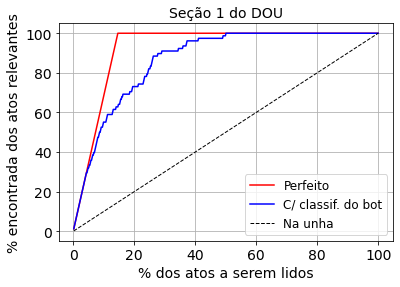

In [111]:
ev.plot_recall_curve(loaded_test_data.relevancia.values, y_pred_loaded_test)

<AxesSubplot:title={'center':'y_pred'}, xlabel='y_true'>

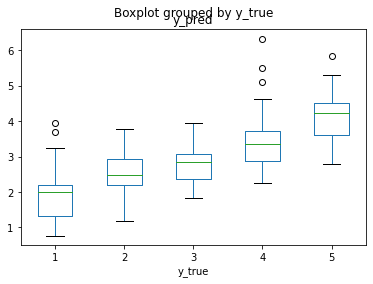

In [112]:
y_pred_true_loaded_df = pd.DataFrame({'y_pred':y_pred_loaded_test, 'y_true': loaded_test_data.relevancia.values}, 
                                     index=loaded_test_data.index)
y_pred_true_loaded_df.boxplot(column='y_pred', by='y_true', grid=False)

#### Test production model on new data

In [32]:
# Get predictions from saved production model:
#loaded_model = joblib.load('../modelos/dou-1_sorter_ridge_2020-05-07/production_model.joblib')
loaded_model = joblib.load('../modelos/dou-1_sorter_ridge_2020-07-23/production_model.joblib')

In [33]:
# Temporary fix:
#dump = loaded_model['pretext'].set_params(cargo_tokens=False)

In [34]:
sorted_test_data_raw = prod_test_data_raw.sort_values('data_pub')
print('# examples:', len(sorted_test_data_raw))

# examples: 954


#### Métricas de avaliação

In [35]:
test_batch_size = 200
for i in range(0, len(sorted_test_data_raw), test_batch_size):
    # Select data:
    sel_test_data_raw = sorted_test_data_raw.iloc[i: i + test_batch_size]
    print(sel_test_data_raw.iloc[0]['data_pub'], '--' ,sel_test_data_raw.iloc[-1]['data_pub'])
    # Predict on new data:
    y_pred_loaded = loaded_model.predict(sel_test_data_raw)
    print('RMSE:       ', np.sqrt(mean_squared_error(sel_test_data_raw.relevancia, y_pred_loaded)))
    print('Cum. Recall:', ev.cum_recall_metric(sel_test_data_raw.relevancia.values, y_pred_loaded))
    print('')

2020-07-23 -- 2020-07-31
RMSE:        0.9143025645576168
Cum. Recall: 0.8836973082783139

2020-07-31 -- 2020-08-18
RMSE:        0.7815673301390489
Cum. Recall: 0.7496392496392495

2020-08-18 -- 2020-08-28
RMSE:        0.9096206728191827
Cum. Recall: 0.8530836293186957

2020-08-28 -- 2020-09-16
RMSE:        0.8674638929610887
Cum. Recall: 0.8319688109161797

2020-09-16 -- 2020-09-28
RMSE:        0.9272646606790771
Cum. Recall: 0.8390476190476193



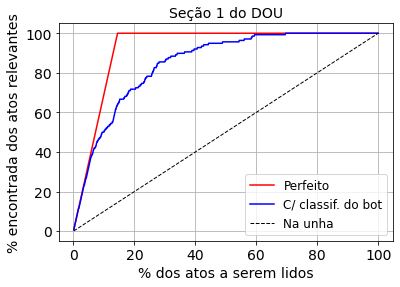

In [37]:
y_pred_loaded = loaded_model.predict(prod_test_data_raw)
ev.plot_recall_curve(prod_test_data_raw.relevancia.values, y_pred_loaded)

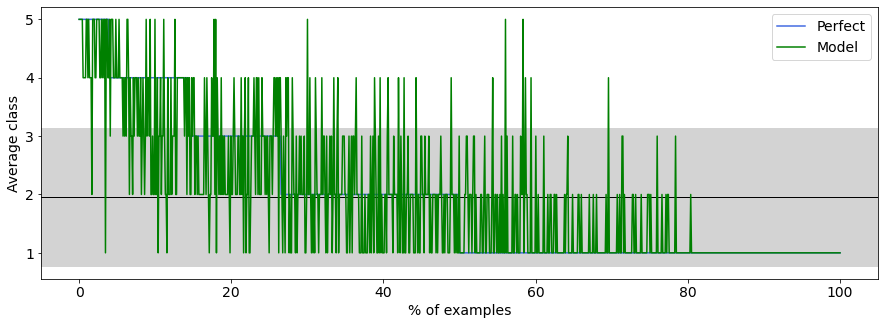

In [41]:
window = 1

pl.figure(figsize=(15,5))
ev.plot_average_rank(prod_test_data_raw['relevancia'].values, prod_test_data_raw['relevancia'].values, window, 
                  color='royalblue', label='Perfect')
ev.plot_average_rank(prod_test_data_raw['relevancia'].values, y_pred_loaded, window, color='g', label='Model')
pl.legend(fontsize=14)
pl.show()

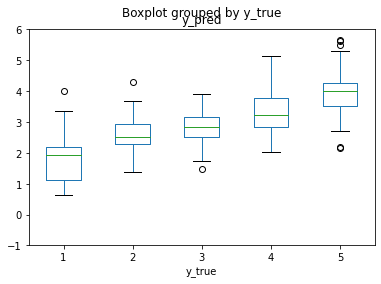

In [39]:
# Join validation true and predicted values:
y_pred_true_loaded_df = pd.DataFrame({'y_pred':y_pred_loaded, 'y_true': prod_test_data_raw['relevancia'].values}, 
                                     index=prod_test_data_raw.index)
y_pred_true_loaded_df.boxplot(column='y_pred', by='y_true', grid=False)
#pl.savefig('plots/box-plot_rank_by_true_label_' + dt.datetime.now().strftime('%Y-%m-%d') + '.png')
pl.ylim([-1,6])
pl.show()

# Lixo

## Multicolumn vectorizer prototyping

In [23]:
def sparse_max(A, B):
    """
    Return the element-wise maximum of sparse matrices `A` and `B`.
    """
    AgtB = (A > B).astype(int)
    M = AgtB.multiply(A - B) + B
    return M

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnVectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorize text columns into a single term frequency matrix, giving 
    different weights to text that appears on different columns. It creates
    a single vocabulary from all columns, transforms each column separately 
    and then aggregate them. 
    
    Input
    -----
            
    text_cols : list of str
        List of `input_df` column names that contain text.
        
    text_weights : list of float
        Weights that multiply the counts made by `vectorizer` on 
        each one of `text_cols` columns.
        
    agg : str
        How to aggregate the counts from each column:
        - 'sum': Sum the counts from each column.
        - 'max': Get the maximum of the counts from the columns.
    
    kwargs : keyword arguments for the sklearn CountVectorizer object
        Parameters for the vectorizer that will be used to vectorize the text columns.
        
    input_df : Pandas DataFrame
        Dataframe containing text columns to be vectorized.

    
    Transform Return
    ----------------
    
    agg_counts : numpy array or sparse matrix
        The aggregated counts of the vocabulary from each column.
    """
    def __init__(self, text_cols, text_weights, agg, **kwargs):
        
        # Load parameters:
        self.text_cols    = text_cols
        self.text_weights = text_weights
        self.agg          = agg
        self.kwargs       = kwargs
        self.vec          = CountVectorizer(**kwargs)
        
        # Valid input checks:
        if agg != 'sum' and agg != 'max':
            raise Exception("Unknown `agg = " + str(self.agg) + "` option. It should be 'sum' or 'max'.") 
        assert len(text_cols) == len(text_weights), '`text_cols` and `text_weights` must have the same length'
    
    def fit(self, X, y=None):
        
        # Select text columns and fill missing values with empty strings:
        text_df   = X[self.text_cols].fillna('')       
        # Create a single column with all texts:
        all_text  = text_df.agg(' '.join, axis=1)
        
        # Fit vectorizer to all text:
        self.vec.fit(all_text)
        
        return self
    
    def transform(self, X):
         
        # Select text columns and fill missing values with empty strings:
        text_df   = X[self.text_cols].fillna('')       
       
        # Vectorize all text columns:
        count_matrices = np.array([w * self.vec.transform(text_df[col]) \
                                       for w, col in zip(self.text_weights, self.text_cols)])
        # Aggregate the results:
        
        # Keep the largest weight:
        if self.agg == 'max':
            agg_counts = count_matrices[0]
            if len(count_matrices) > 1:
                for count_matrix in count_matrices[1:]:
                    agg_counts = sparse_max(agg_counts, count_matrix)
        # Sum the weights:
        elif self.agg == 'sum':
            count_matrices = np.array([w * self.vec.transform(text_df[col]) \
                                       for w, col in zip(self.text_weights, self.text_cols)])
            agg_counts = count_matrices.sum(axis=0)
        else:
            raise Exception("Unknown `agg = " + str(self.agg) + "` option. It should be 'sum' or 'max'.") 

        return agg_counts

## Old stuff

In [ ]:
def array_derivative(y, x=None):
    """
    Given an array `y` and and optional array `x`, compute the derivative
    dy / dx (x = [0,1,...,N-1] if unespecified, where N = len(y)). The 
    derivative value is attributed to the initial point used in the calculation,
    and the final value is extrapolated from the last two points in x and y.
    """
    if x != None:
        dx = np.diff(x)
        assert np.all(np.isclose(dx, np.ones(len(dx)) * dx[0])), 'x should be linearly spaced.'
        dx = np.append(dx, dx[-1])
    dy = np.diff(y)
    # Extrapolate derivative
    dy = np.append(dy, [dy[-1] + dy[-1] - dy[-2]])
    if x == None:
        return dy
    else:
        return dy / dx

### GridSeach na mão

In [45]:
text_cols = ['titulo', 'orgao', 'ementa', 'fulltext']
colunas_relevantes = ['relevancia', 'tipo_edicao'] + text_cols
stopwords = nltk.corpus.stopwords.words('portuguese')
dou_extractor = do.PreprocessDOU(colunas_relevantes, 'xxnuloxx')
proc_text = do.PreProcessText(lowercase=True, remove_punctuation=True, keep_cash=True, stopwords=stopwords, 
                              stemmer=None, strip_accents=False, only_letters=True, cargo_tokens=True,
                              text_cols=text_cols)

pre_pipe = Pipeline([('dou', dou_extractor), ('text', proc_text)])

In [65]:
train_proc = pre_pipe.transform(train_raw)
val_proc = pre_pipe.transform(val_raw)

In [66]:
vec = ml.MultiColumnVectorizer(text_cols, [0,1,0,1], 'max', 
                            lowercase=False, binary=True, ngram_range=(1,1), max_df=1.0, min_df=1)

final_pipe = Pipeline([('vec', vec), ('fit', clas)])

dump = final_pipe.fit(train_proc, train_proc.relevancia.values)
ev.cum_recall_metric(val_proc.relevancia.values, final_pipe.predict(val_proc))

0.7815585740114043

### Teste de duas pipelines

In [105]:
reload(ml)

<module 'mltools' from '/home/skems/prog/my-python/mltools.py'>

In [106]:
text_cols = ['titulo', 'orgao', 'ementa', 'fulltext']
colunas_relevantes = ['relevancia', 'tipo_edicao'] + text_cols
stopwords = nltk.corpus.stopwords.words('portuguese')
dou_extractor = do.PreprocessDOU(colunas_relevantes, 'xxnuloxx')
proc_text = do.PreProcessText(lowercase=True, remove_punctuation=True, keep_cash=True, stopwords=stopwords, 
                              stemmer=None, strip_accents=False, only_letters=True, cargo_tokens=True,
                              text_cols=text_cols)
vec = ml.MultiColumnVectorizer(text_cols, [1,1,1,1], 'max', 
                            lowercase=False, binary=True, ngram_range=(1,1), max_df=1.0, min_df=1)
clas = Ridge(300)

pipe2 = Pipeline([('dou', dou_extractor), ('text', proc_text), ('vec', vec), ('fit', clas)])

In [107]:
dump = pipe2.fit(train_raw, train_raw.relevancia.values)
ev.cum_recall_metric(val_raw.relevancia.values, pipe2.predict(val_raw))

0.7920356033563579

In [26]:
text_cols = ['tit_org_ementa_text']
colunas_relevantes = ['relevancia', 'tipo_edicao'] + text_cols
stopwords = nltk.corpus.stopwords.words('portuguese')
dou_extractor = do.PreprocessDOU(colunas_relevantes, 'xxnuloxx')
proc_text = do.PreProcessText(lowercase=True, remove_punctuation=True, keep_cash=True, stopwords=stopwords, 
                              stemmer=None, strip_accents=False, only_letters=True, cargo_tokens=True,
                              text_cols=text_cols)
vec = CountVectorizer(lowercase=False, binary=True, ngram_range=(1,1), max_df=1.0, min_df=1)
col = ColumnTransformer([('vec', vec, text_cols[0])])
clas = Ridge(300)

pipe1 = Pipeline([('dou', dou_extractor), ('text', proc_text), ('vec', col), ('clas', clas)])

In [27]:
dump = pipe1.fit(train_raw, train_raw.relevancia.values)
ev.cum_recall_metric(val_raw.relevancia.values, pipe1.predict(val_raw))

0.7918501692086597

## Construindo um vectorizer com pesos

In [51]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [252]:
def sparse_max(A, B):
    """
    Return the element-wise maximum of sparse matrices `A` and `B`.
    """
    AgtB = (A > B).astype(int)
    M = AgtB.multiply(A - B) + B
    return M

In [279]:
def multicol_counts(vectorizer, input_df, text_cols, text_weights, agg):
    """
    Vectorize text columns into a single term frequency matrix, giving 
    different weights to text that appears on different columns. It creates
    a single vocabulary from all columns, transforms each column separately 
    and then aggregate them. 
    
    Input
    -----
    
    vectorizer : sklearn CountVectorizer object
        The vectorizer that will be used to vectorize the text columns.
        It gets modified by this function in place.
        
    input_df : Pandas DataFrame
        Dataframe containing text columns to be vectorized.
        
    text_cols : list of str
        List of `input_df` column names that contain text.
        
    text_weights : list of float
        Weights that multiply the counts made by `vectorizer` on 
        each one of `text_cols` columns.
        
    agg : str
        How to aggregate the counts from each column:
        - 'sum': Sum the counts from each column.
        - 'max': Get the maximum of the counts from the columns.
        
    Return
    ------
    
    agg_counts : numpy array or sparse matrix
        The aggregated counts of the vocabulary from each column.
    """
    
    # Select text columns and fill missing values with empty strings:
    text_df   = input_df[text_cols].fillna('')
    # Create a single column with all texts:
    all_text  = text_df.agg(' '.join, axis=1)
    
    # Fit vectorizer to all text:
    vectorizer.fit(all_text)
    
    # Vectorize all text columns:
    count_matrices = np.array([w * vectorizer.transform(text_df[col]) for w, col in zip(text_weights, text_cols)])
    
    # Aggregate the results:
    if agg == 'max':        
        agg_counts = count_matrices[0]
        if len(count_matrices) > 1:
            for count_matrix in count_matrices[1:]:
                agg_counts = sparse_max(agg_counts, count_matrix)
        
    elif agg == 'sum':
        agg_counts = count_matrices.sum(axis=0)
    else:
        raise Exception("Unknown `agg = " + str(agg) + "` option. It should be 'sum' or 'max'.") 
    
    return agg_counts

In [61]:
from scipy import sparse

In [290]:
df = pd.DataFrame({'t1': ['portaria', 'portaria', 'decreto'], 't2': ['coisa ruim', 'nem avisa', 'altera o decreto'], 't3': ['fala qualquer coisa', 'coisa ruim', 'verifica a portaria']})

In [291]:
df

,t1,t2,t3
0,portaria,coisa ruim,fala qualquer coisa
1,portaria,nem avisa,coisa ruim
2,decreto,altera o decreto,verifica a portaria


In [298]:
v = CountVectorizer(binary=True)
d = multicol_counts(v, df, ['t1', 't2', 't3'], [1, 1, 1], 'max').A

In [299]:
pd.DataFrame(data=d, columns=v.get_feature_names())

,altera,avisa,coisa,decreto,fala,nem,portaria,qualquer,ruim,verifica
0,0,0,1,0,1,0,1,1,1,0
1,0,1,1,0,0,1,1,0,1,0
2,1,0,0,1,0,0,1,0,0,1


In [257]:
# Testing max of sparse matrix:

A = sparse.csr_matrix(np.random.randint(-9,10, 25).reshape((5,5))) 
B = sparse.csr_matrix(np.random.randint(-9,10, 25).reshape((5,5)))

M = sparse_max(A, B)
M2 = sparse_max(B, A)

# Test symmetry:
print((M.A == M2.A).all())
# Test that M is larger or equal to A and B, element-wise:
print((M.A >= A.A).all())
print((M.A >= B.A).all())

# Anotações sobre python

#### Invertendo um dicionário

In [43]:
{w:k for k,w in class_to_weight.items()}

NameError: name 'class_to_weight' is not defined

#### Usando `*args` e `**kwargs`

Dentro da função, o `arg` de `*arg` é tratado como uma tupla.

In [44]:
def teste(x, *arg):
    print(x)
    for a in arg:
        print(a)
    print(arg)
    print(type(arg))

In [45]:
teste(1, 'aba', 't', -1)

1
aba
t
-1
('aba', 't', -1)
<class 'tuple'>


In [46]:
teste(1, *(10,20,30))

1
10
20
30
(10, 20, 30)
<class 'tuple'>


`kmargs` significa **k**ey**w**ord arguments. Dentro da função, o `kwargs` é tratado como dicionário.

In [47]:
def teste(x, **kwargs):
    print(x)
    print(kwargs)
    print(type(kwargs))
    print(kwargs['abacate'])

In [48]:
teste(1, abacate=2, felix='coco', blob=1000)

1
{'abacate': 2, 'felix': 'coco', 'blob': 1000}
<class 'dict'>
2


In [49]:
teste(1, **{'abacate':1, 'y':2})

1
{'abacate': 1, 'y': 2}
<class 'dict'>
1
